# Packages

In [1]:
# Packages
import zipfile
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


import imageio
import cv2

# Mount and Load Data

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# open zip file
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Springboard - Capstone 3/Data/combinedData.zip', 'r')

# create folder with combined data
zip_ref.extractall('/content/BloodCellData')
zip_ref.close()

I decided to combine the train and test folder into one data set to remove any augmentation bias or issues done to either the train or test set to ensure the testing set will reflect the training and validation sets. The author has provided a description of the dataset, but not enough details about the augmentation. From there I divided the dataset into train, validation, and test data sets.

## Split the Data into Train, Validation, Test Sets

In [4]:
# Train Data Directory
datadir = '../content/BloodCellData/Combined Data'

print("Data Directory Folders:", os.listdir(datadir))

Data Directory Folders: ['MONOCYTE', 'NEUTROPHIL', 'EOSINOPHIL', 'LYMPHOCYTE']


In [5]:
# Image Size
image_width = 320
image_height = 240

# Split the data to training
train_images = tf.keras.utils.image_dataset_from_directory(
    datadir,
    label_mode='int',
    validation_split=0.30,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=(image_height, image_width))

# Split the data to validation and testing
val_test_images = tf.keras.utils.image_dataset_from_directory(
    datadir,
    label_mode='int',
    validation_split=0.30,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(image_height, image_width))

# Split the val_test_images into validation and testing images
validation_images = val_test_images.take(int(len(val_test_images) * 0.5))
test_images = val_test_images.skip(int(len(val_test_images) * 0.5))

Found 12436 files belonging to 4 classes.
Using 8706 files for training.
Found 12436 files belonging to 4 classes.
Using 3730 files for validation.


In [6]:
# Class Names
class_names = train_images.class_names
print(class_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


## Quick Review of the Split Data

### Class Distribution

In [7]:
def class_distribution(img_set):
  '''
  Function counts the sample number for each class for graphical distribution
  '''
  
  class0 = 0
  class1 = 0
  class2 = 0
  class3 = 0
  
  for images, labels in img_set:
    lab = labels.numpy()
    
    id, counts = np.unique(lab, return_counts=True)
    
    if (len(counts) == 4):
      class0 += counts[0]
      class1 += counts[1]
      class2 += counts[2]
      class3 += counts[3]
    elif (len(counts) == 3):
      class0 += counts[0]
      class1 += counts[1]
      class2 += counts[2]
    elif (len(counts) == 2):
      class0 += counts[0]
      class1 += counts[1]
    else:
      class0 += counts[0]
  
  # Pie Chart of the Distribution
  print('EOSINOPHIL:', class0)
  print('LYMPHOCYTE:', class1)
  print('MONOCYTE:', class2)
  print('NEUTROPHIL:', class3)
  
  image_counts = [class0, class1, class2, class3]
  
  plt.pie(image_counts, labels=class_names, autopct='%1.1f%%')
  plt.show()

EOSINOPHIL: 2203
LYMPHOCYTE: 2168
MONOCYTE: 2172
NEUTROPHIL: 2163


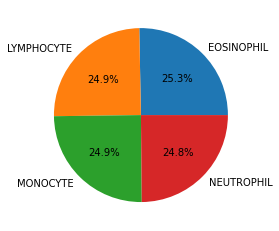

In [8]:
# Train Image Set
class0 = 0
class1 = 0
class2 = 0
class3 = 0

for images, labels in train_images.take(-1):
  lab = labels.numpy()
  
  id, counts = np.unique(lab, return_counts=True)
  
  if (len(counts) == 4):
    class0 += counts[0]
    class1 += counts[1]
    class2 += counts[2]
    class3 += counts[3]
  elif (len(counts) == 3):
    class0 += counts[0]
    class1 += counts[1]
    class2 += counts[2]
  elif (len(counts) == 2):
    class0 += counts[0]
    class1 += counts[1]
  else:
    class0 += counts[0]
  

# Pie Chart of the Distribution
print('EOSINOPHIL:', class0)
print('LYMPHOCYTE:', class1)
print('MONOCYTE:', class2)
print('NEUTROPHIL:', class3)

image_counts = [class0, class1, class2, class3]
image_cellType = ['EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE', 'NEUTROPHIL']

plt.pie(image_counts, labels=class_names, autopct='%1.1f%%')
plt.show()

EOSINOPHIL: 435
LYMPHOCYTE: 471
MONOCYTE: 474
NEUTROPHIL: 476


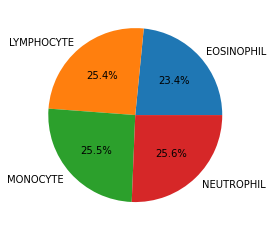

In [9]:
# Validation Image Distribution
class_distribution(validation_images)

EOSINOPHIL: 482
LYMPHOCYTE: 460
MONOCYTE: 444
NEUTROPHIL: 488


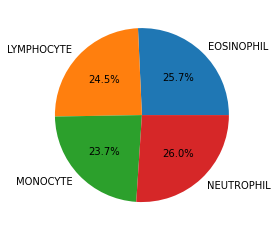

In [10]:
# Test Image Distribution
class_distribution(test_images)

### Sample Images

In [11]:
# Image Sets
img_sets = [train_images, validation_images, test_images]

In [12]:
# Display shape of batches
for img_set in img_sets:
  for image_batch, labels_batch in img_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 240, 320, 3)
(32,)
(32, 240, 320, 3)
(32,)
(32, 240, 320, 3)
(32,)


In [13]:
def display_sampleset(image_set, title):
  plt.figure(figsize=(15, 15))

  for images, labels in image_set.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.suptitle(title, size=20)
      plt.axis("off")

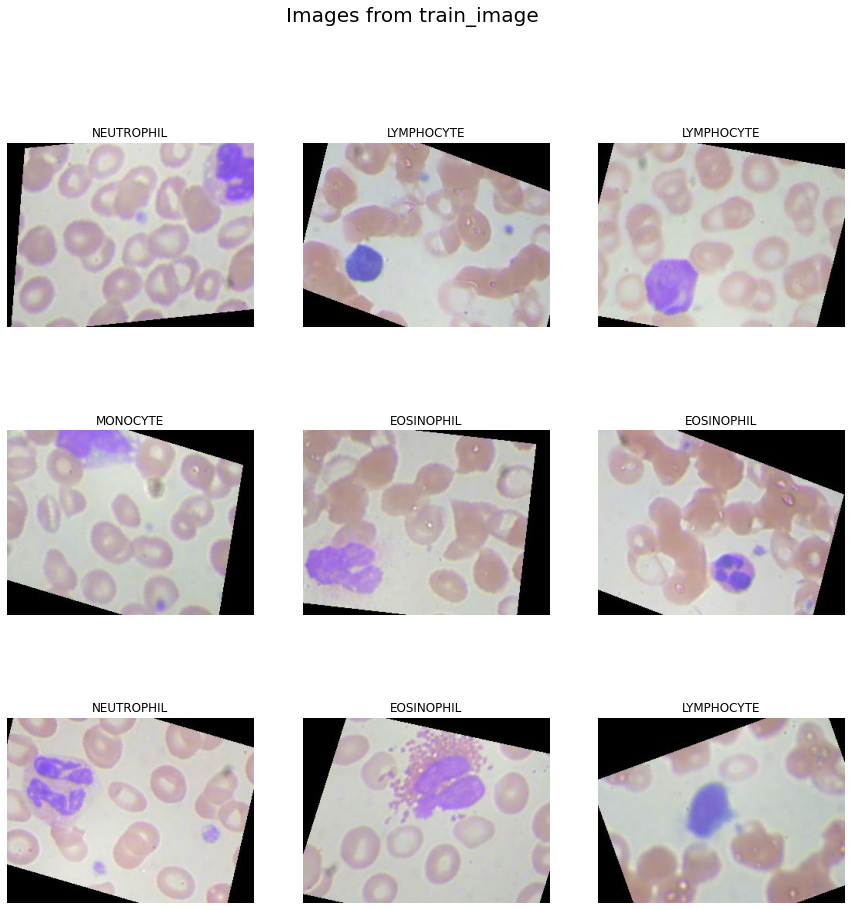

In [14]:
# Display images from first batch of train_image split
display_sampleset(train_images, "Images from train_image")

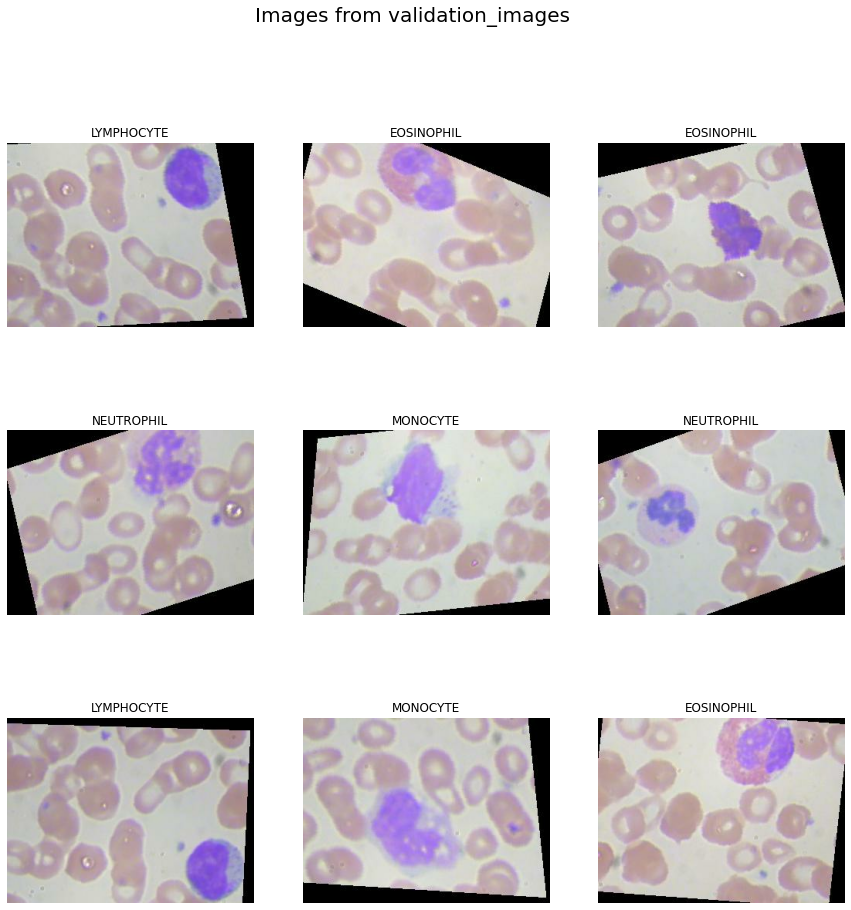

In [15]:
# Display images from first batch of validation_images split
display_sampleset(validation_images, "Images from validation_images")

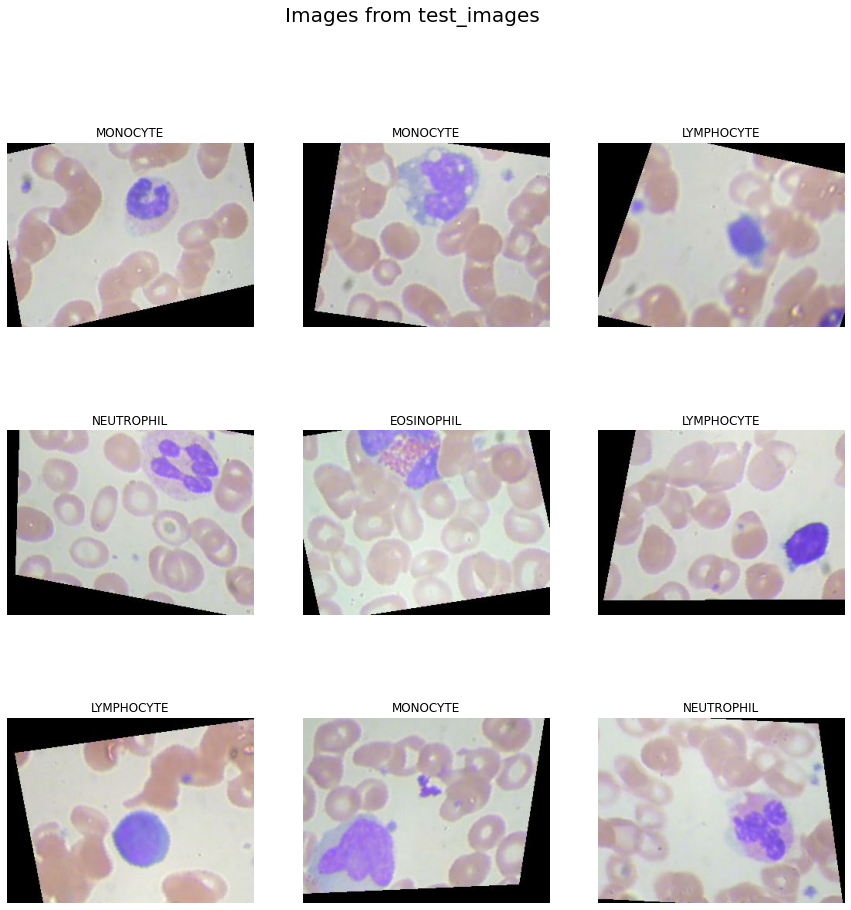

In [16]:
# Display images from first batch of test_images split
display_sampleset(test_images, "Images from test_images")

# Building Base Model using Transfer Learning with Keras.Xeception

In [17]:
# Using transfer learning base model Xception
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(image_height, image_width, 3),
    include_top=False
)

# Freezing base_model
base_model.trainable = False

# Input shape of images
inputs = tf.keras.Input(shape=(image_height, image_width, 3))

# Rescales using Xception preprocessing to (-1,1)
x = tf.keras.applications.xception.preprocess_input(inputs)

# Add top layer to base_model
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.20)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.20)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.20)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.20)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.20)(x)
x = tf.keras.layers.Dense(8, activation='relu')(x)
x = tf.keras.layers.Dropout(0.20)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)


model = tf.keras.Model(inputs, outputs)

model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 240, 320, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 240, 320, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 10, 2048)       20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                       

In [18]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
# Test model function
def Model_Test(img_set):
  loss, accuracy = model.evaluate(img_set)

  print("Loss:", loss)
  print("Accuracy", accuracy)

## Evaluation of Base Model Test

In [20]:
# Baseline testing
Model_Test(test_images)

59/59 [==============================] - 18s 133ms/step - loss: 1.3840 - accuracy: 0.2593
Loss: 1.3839701414108276
Accuracy 0.2593383193016052


## Train Base Model

In [21]:
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            mode='min',
                                            min_delta=0.005,
                                            patience=5,
                                            restore_best_weights=True)

In [22]:
# Train base model
initial_epochs = 60
history = model.fit(train_images, 
                    epochs=initial_epochs, 
                    validation_data=validation_images,
                    callbacks=[early_stopping])

Epoch 1/60
273/273 [==============================] - 46s 157ms/step - loss: 1.3800 - accuracy: 0.2734 - val_loss: 1.3413 - val_accuracy: 0.3448
Epoch 2/60
273/273 [==============================] - 43s 156ms/step - loss: 1.3221 - accuracy: 0.3470 - val_loss: 1.2444 - val_accuracy: 0.4359
Epoch 3/60
273/273 [==============================] - 44s 161ms/step - loss: 1.2551 - accuracy: 0.4040 - val_loss: 1.1790 - val_accuracy: 0.4617
Epoch 4/60
273/273 [==============================] - 43s 158ms/step - loss: 1.2161 - accuracy: 0.4397 - val_loss: 1.1535 - val_accuracy: 0.4925
Epoch 5/60
273/273 [==============================] - 43s 157ms/step - loss: 1.1739 - accuracy: 0.4753 - val_loss: 1.0932 - val_accuracy: 0.5318
Epoch 6/60
273/273 [==============================] - 43s 157ms/step - loss: 1.1305 - accuracy: 0.4956 - val_loss: 1.0420 - val_accuracy: 0.5673
Epoch 7/60
273/273 [==============================] - 43s 157ms/step - loss: 1.1008 - accuracy: 0.5140 - val_loss: 1.0192 - val_ac

In [23]:
# Save the trained base model
saved_models_path = '/content/drive/MyDrive/Colab Notebooks/Springboard - Capstone 3/Saved_Models'

if os.path.exists(saved_models_path) == False:
  os.mkdir(saved_models_path)

trained_base_model = os.path.join(saved_models_path, "trained_base_model.h5")
model.save(trained_base_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [24]:
# Code for Loading trained base model
# model = tf.keras.models.load_model(trained_base_model)

### Metric Evaluation

In [25]:
# Collect the Metrics values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

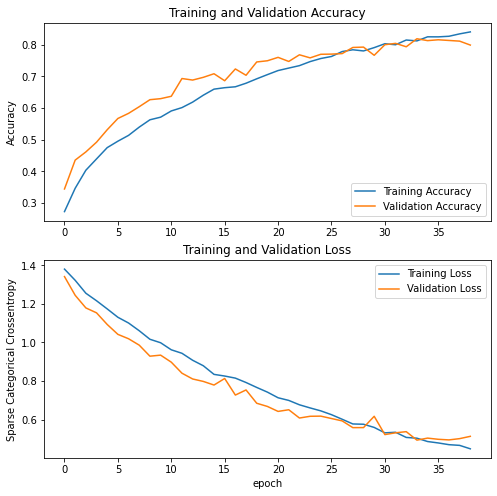

In [26]:
# Plot the Metrics values
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Categorical Crossentropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

### Evaluation of Trained Base Model Test

In [27]:
# Evaluation of trained base model on test images
Model_Test(test_images)

59/59 [==============================] - 9s 129ms/step - loss: 0.4967 - accuracy: 0.8180
Loss: 0.4967297613620758
Accuracy 0.8180362582206726


# Fine Tuning the Model

In [28]:
# Unfreeze the Entire Model for training at a very low rate
base_model.trainable = True

In [29]:
# Compile the new model with the unfrozen base model with the trained weights
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 240, 320, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 240, 320, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 10, 2048)       20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [30]:
# Fine tune the model for 30 more epochs
fine_tune_epochs = 40
total_epoch = fine_tune_epochs + history.epoch[-1]

history_fine = model.fit(train_images, 
                     epochs=total_epoch,
                     initial_epoch=history.epoch[-1]+1, #Start epoch from where it was left off
                     validation_data=validation_images,
                     callbacks=[early_stopping])

Epoch 40/78
273/273 [==============================] - 189s 672ms/step - loss: 0.4197 - accuracy: 0.8504 - val_loss: 0.4225 - val_accuracy: 0.8459
Epoch 41/78
273/273 [==============================] - 183s 670ms/step - loss: 0.3595 - accuracy: 0.8680 - val_loss: 0.3863 - val_accuracy: 0.8621
Epoch 42/78
273/273 [==============================] - 183s 669ms/step - loss: 0.3295 - accuracy: 0.8824 - val_loss: 0.3528 - val_accuracy: 0.8739
Epoch 43/78
273/273 [==============================] - 183s 670ms/step - loss: 0.3072 - accuracy: 0.8873 - val_loss: 0.3236 - val_accuracy: 0.8912
Epoch 44/78
273/273 [==============================] - 183s 670ms/step - loss: 0.2943 - accuracy: 0.8952 - val_loss: 0.3054 - val_accuracy: 0.8955
Epoch 45/78
273/273 [==============================] - 183s 670ms/step - loss: 0.2737 - accuracy: 0.9004 - val_loss: 0.2838 - val_accuracy: 0.8992
Epoch 46/78
273/273 [==============================] - 183s 669ms/step - loss: 0.2598 - accuracy: 0.9013 - val_loss: 0

In [31]:
# Save the trained tuned model
trained_tuned_model = os.path.join(saved_models_path, "trained_tuned_model.h5")
model.save(trained_tuned_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [32]:
# Code for Loading trained tuned model
# model = tf.keras.models.load_model(trained_tuned_model)

## Metric Evaluation

In [33]:
# Collect the Metrics values
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

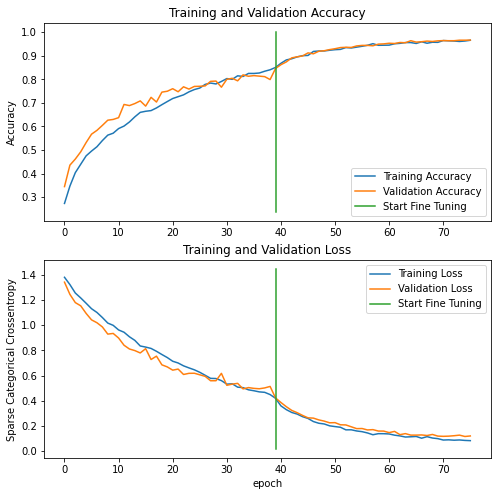

In [34]:
# Plot the Metrics values
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([history.epoch[-1]+1,history.epoch[-1]+1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([history.epoch[-1]+1,history.epoch[-1]+1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Sparse Categorical Crossentropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

## Evaluation of Fine Tuned Model Test

In [35]:
loss, accuracy = model.evaluate(test_images)
print("Loss:", loss)
print("Accuracy:", accuracy)

59/59 [==============================] - 9s 129ms/step - loss: 0.1065 - accuracy: 0.9642
Loss: 0.10650672018527985
Accuracy: 0.9642475843429565
